In [60]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [66]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [62]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [63]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

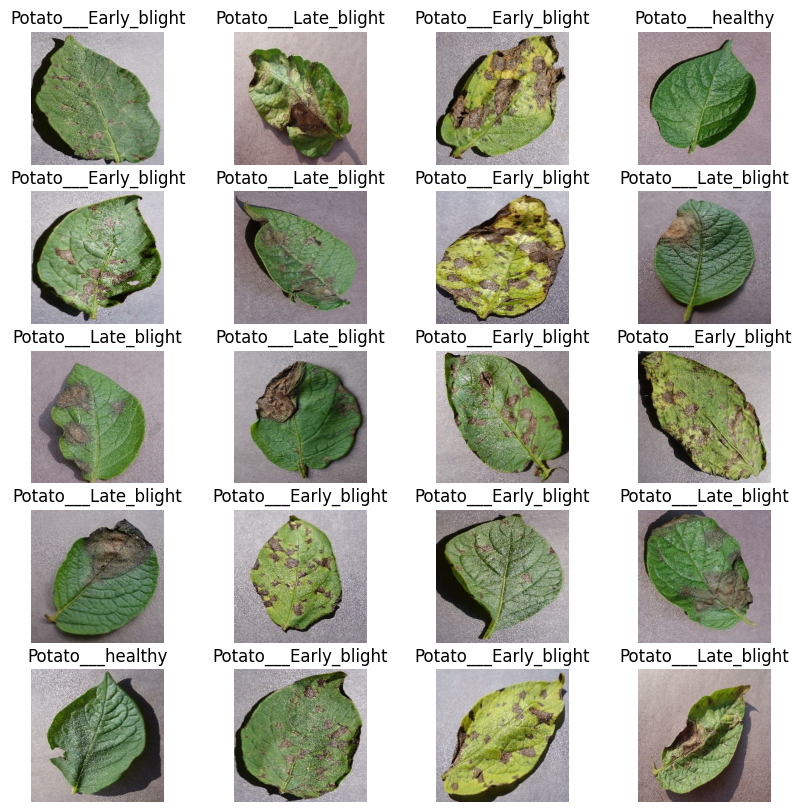

In [64]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [67]:
len(dataset)

68

In [68]:
def get_dataset_repartition_tf(ds,train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split*ds_size)
    
    val_size = int(val_split* ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [69]:
train_ds, val_ds, test_ds = get_dataset_repartition_tf(dataset)

In [70]:
len(train_ds)

54

In [71]:
len(val_ds)

6

In [72]:
len(test_ds)

8

Optimised performances

In [73]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [74]:
resize_and_rescale =  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [75]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Modeling

In [76]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS) 
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = input_shape)

In [77]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [78]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [79]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 30s 535ms/step - loss: 0.8984 - accuracy: 0.4861 - val_loss: 0.8223 - val_accuracy: 0.5156
Epoch 2/50
54/54 [==============================] - 29s 536ms/step - loss: 0.7273 - accuracy: 0.6684 - val_loss: 0.7345 - val_accuracy: 0.7656
Epoch 3/50
54/54 [==============================] - 29s 542ms/step - loss: 0.6298 - accuracy: 0.7384 - val_loss: 0.5420 - val_accuracy: 0.7865
Epoch 4/50
54/54 [==============================] - 30s 558ms/step - loss: 0.5021 - accuracy: 0.8137 - val_loss: 0.4287 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 30s 562ms/step - loss: 0.4143 - accuracy: 0.8362 - val_loss: 0.3736 - val_accuracy: 0.8281
Epoch 6/50
54/54 [==============================] - 31s 566ms/step - loss: 0.3538 - accuracy: 0.8547 - val_loss: 0.2809 - val_accuracy: 0.8854
Epoch 7/50
54/54 [==============================] - 31s 567ms/step - loss: 0.3092 - accuracy: 0.8681 - val_loss: 0.3667 - val_accuracy: 0.8333

In [80]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 143ms/step - loss: 0.0595 - accuracy: 0.9805


In [81]:
scores

[0.059519048780202866, 0.98046875]

In [82]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [83]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [84]:
history.history["accuracy"]

[0.4861111044883728,
 0.6684027910232544,
 0.7384259104728699,
 0.8136574029922485,
 0.8362268805503845,
 0.8547453880310059,
 0.8680555820465088,
 0.9149305820465088,
 0.9212962985038757,
 0.9184027910232544,
 0.9103009104728699,
 0.9467592835426331,
 0.9537037014961243,
 0.9508101940155029,
 0.9600694179534912,
 0.953125,
 0.9583333134651184,
 0.9525462985038757,
 0.9600694179534912,
 0.9716435074806213,
 0.9646990895271301,
 0.9635416865348816,
 0.9641203880310059,
 0.9774305820465088,
 0.9797453880310059,
 0.9606481194496155,
 0.9554398059844971,
 0.9768518805503845,
 0.9241898059844971,
 0.9733796119689941,
 0.9745370149612427,
 0.9762731194496155,
 0.9785879850387573,
 0.9814814925193787,
 0.9826388955116272,
 0.9890046119689941,
 0.9832175970077515,
 0.9820601940155029,
 0.9866898059844971,
 0.9820601940155029,
 0.9849537014961243,
 0.9820601940155029,
 0.984375,
 0.9733796119689941,
 0.9901620149612427,
 0.9936342835426331,
 0.9918981194496155,
 0.9901620149612427,
 0.983796298

In [85]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

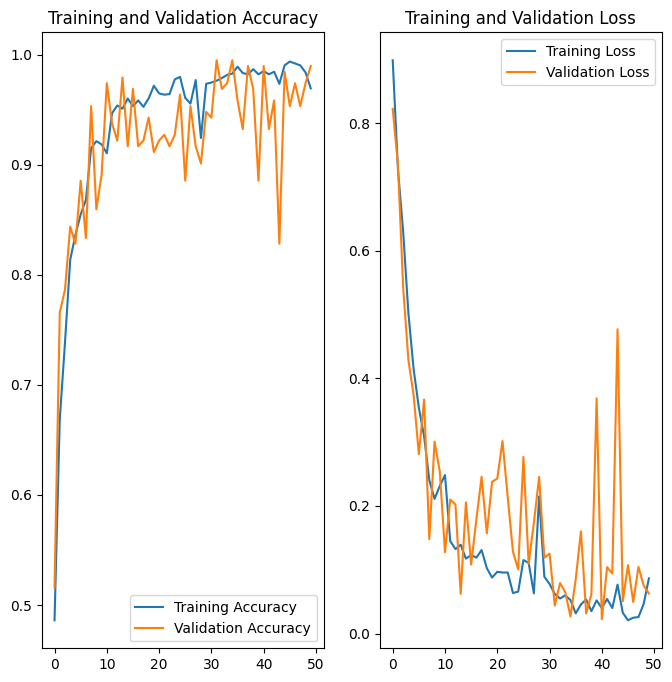

In [86]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

In [87]:
import numpy as np

first image to predict
first image's actual label:  Potato___Early_blight
1/1 [==============================] - 0s 182ms/step
predicted label: Potato___Early_blight


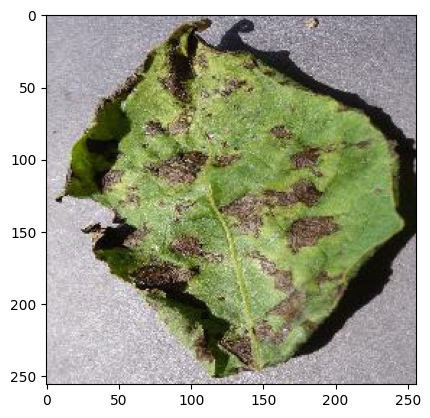

In [88]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint32')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch) #Prediction for 32 images
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [89]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Creates a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


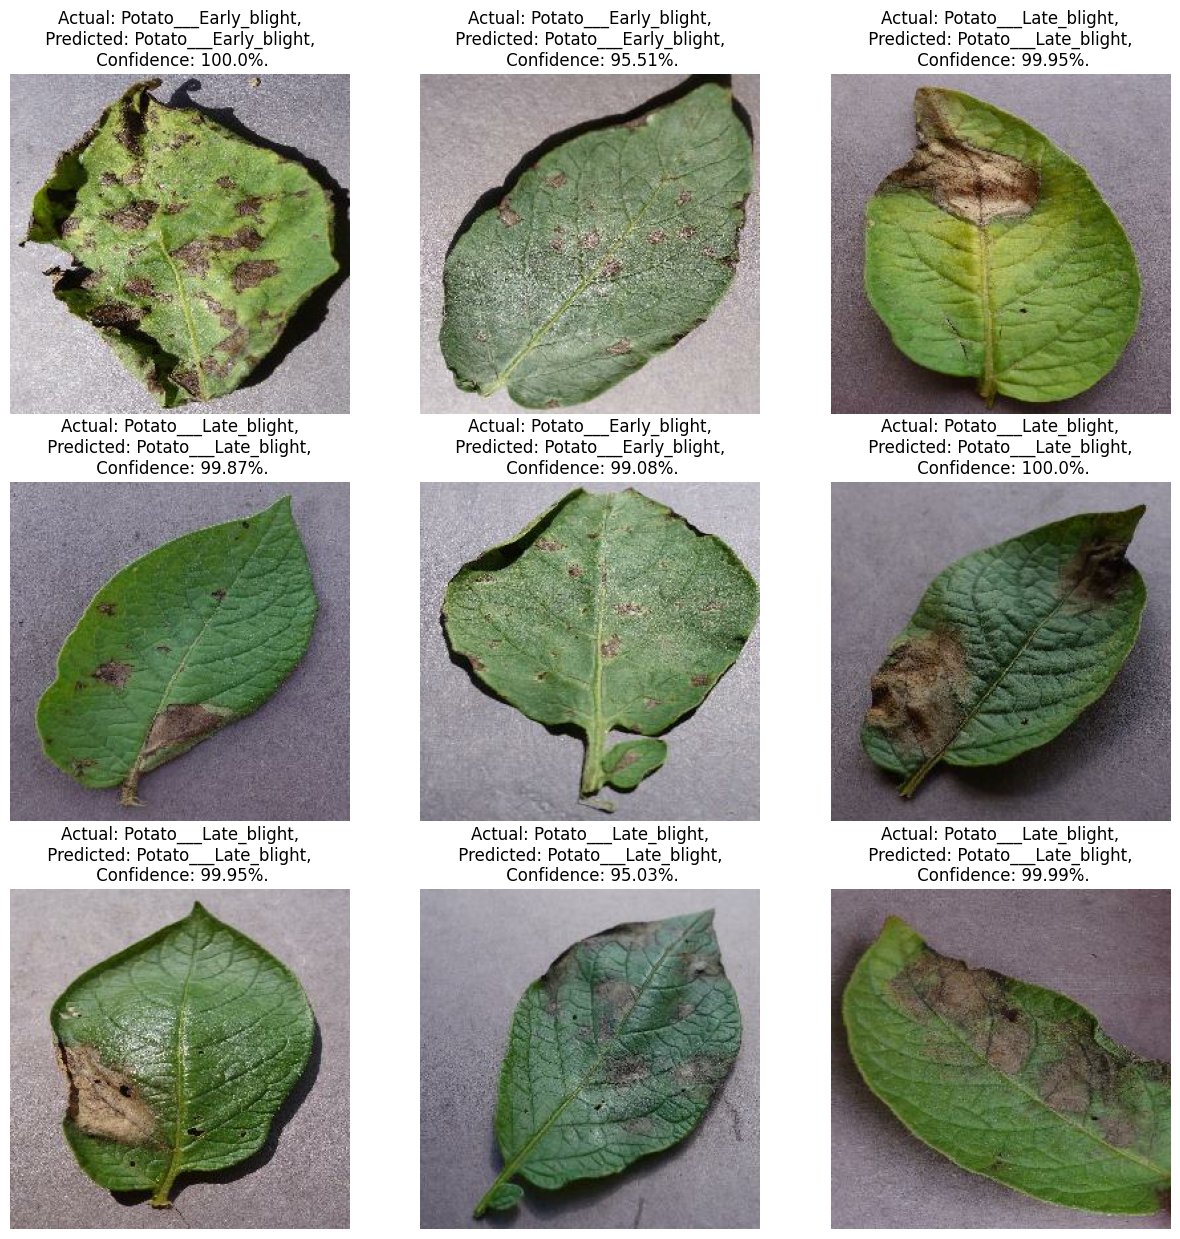

In [90]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence}%.")
        plt.axis("off")

In [91]:
import os

In [92]:
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model_version = str(model_version) + "_epochs" + str(EPOCHS)
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2_epochs50/assets


INFO:tensorflow:Assets written to: ../models/2_epochs50/assets
